In [1]:
## Import Libraries and Initialize Spark Session
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import log, sqrt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.master("local[1]").appName('SparkApp')\
    .config("spark.executor.memory", "4g")\
    .config("spark.driver.memory", "4g")\
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/09 04:50:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
## Load Data
# Assuming 'Datasets' is a folder in the parent directory of your current notebook location
# 假设CSV文件位于"Datasets"文件夹中，该文件夹位于当前Jupyter Notebook的父目录
wec1_path = "../722lab/Datasets/WEC-1.csv"
wec2_path = "../722lab/Datasets/WEC-2.csv"

wec1_data = spark.read.csv(wec1_path, header=True, inferSchema=True)
wec2_data = spark.read.csv(wec2_path, header=True, inferSchema=True)



In [4]:
## Data Preprocessing

# Merge Datasets
merged_data = wec1_data.join(wec2_data, ['country', 'year', 'iso_code'], how='inner')
print("Merged Data")
merged_data.show(5)

# Unpersist the old DataFrames
wec1_data.unpersist()
wec2_data.unpersist()




Merged Data


23/10/09 04:50:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+----+--------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+----------------------+----------------------+------------------+-----------------------+-----------------------+--------------------+-----------------------+-------------------+-----------------------+---------------------+---------------+--------------------+-----------------+--------------------+----------------+--------------------+--------------------+---------------+--------------------+----------------------+-------------------+----------------+------------------+---------------+-----------------+-------------------+---------------+---------------------------+---------------------------------------+----------------------+-----------------+----------------+--------------+-----------------+----------------------+-------------------+----------------------+-----------------------+------------------------+----------------------+---------

DataFrame[iso_code: string, country: string, year: int, fossil_cons_per_capita: double, fossil_share_elec: double, gas_share_elec: double, gas_cons_change_pct: double, gas_share_energy: double, gas_cons_change_twh: double, gas_consumption: double, gas_elec_per_capita: double, gas_energy_per_capita: double, gas_production: double, gas_prod_per_capita: double, hydro_share_elec: double, hydro_cons_change_pct: double, hydro_share_energy: double, hydro_cons_change_twh: double, hydro_consumption: double, hydro_elec_per_capita: double, hydro_energy_per_capita: double, low_carbon_share_elec: double, low_carbon_electricity: double, low_carbon_elec_per_capita: double, low_carbon_cons_change_pct: double, low_carbon_share_energy: double, low_carbon_cons_change_twh: double, low_carbon_consumption: double, low_carbon_energy_per_capita: double, nuclear_share_elec: double, nuclear_cons_change_pct: double, nuclear_share_energy: double, nuclear_cons_change_twh: double, nuclear_consumption: double, nucle

In [5]:
# Filter rows where year > 1966
merged_data = merged_data.filter(F.col("year") > 1966)

# Remove columns with more than 50% missing values
total_rows = merged_data.count()
for col in merged_data.columns:
    missing_count = merged_data.filter(F.col(col).isNull()).count()
    if missing_count / total_rows > 0.5:
        merged_data = merged_data.drop(col)
        

# Handle Missing Values right after column filtering
for col in merged_data.columns:
    # Fill numerical missing values with mean
    if isinstance(merged_data.schema[col].dataType, (DoubleType, IntegerType)):
        mean_value = merged_data.select(F.mean(F.col(col)).alias('mean')).collect()[0]['mean']
        merged_data = merged_data.fillna(mean_value, subset=[col])
    # Fill categorical missing values with the mode
    else:
        mode_list = merged_data.groupBy(col).count().orderBy(F.desc("count")).limit(1).collect()
        mode_value = mode_list[0][col] if mode_list else "Unknown"  # Replace "Unknown" with an appropriate value

        if mode_value is not None:
            merged_data = merged_data.fillna(mode_value, subset=[col])
        else:
            # Handle the case where mode_value is None, perhaps set it to a default value
            merged_data = merged_data.fillna("Unknown", subset=[col])  # Replace "Unknown" with an appropriate value


In [6]:
# Identify numeric columns
numeric_cols = [col[0] for col in merged_data.dtypes if col[1] in ['int', 'double']]


# Check Data Types
print({col: type(merged_data.schema[col].dataType) for col in numeric_cols})

# Check for Extreme Values
for col in numeric_cols:
    min_val = merged_data.agg({col: 'min'}).collect()[0][0]
    max_val = merged_data.agg({col: 'max'}).collect()[0][0]
    print(f"{col}: Min: {min_val}, Max: {max_val}")

# Check for Null or NaN values in PySpark DataFrame
null_check = merged_data.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in merged_data.columns])

# Show columns with Null or NaN values
null_columns = [col for col, cnt in null_check.collect()[0].asDict().items() if cnt > 0]


# Assemble vector for correlation calculation
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
assembled_data = assembler.transform(merged_data)

# Calculate Spearman correlation
try:
    corr_matrix = Correlation.corr(assembled_data, "features", "spearman").collect()[0][0].toArray()
    print("Correlation calculated successfully.")
except Exception as e:
    print(f"Failed to calculate correlation: {e}")


# Calculate Spearman correlation
corr_matrix = Correlation.corr(assembled_data, "features", "spearman").collect()[0][0].toArray()

# Convert Spark DataFrame to Pandas for Spearman correlation
merged_data_pd = merged_data.toPandas()

# Compute Spearman correlation in Pandas and find the top features
spearman_correlations = merged_data_pd.corr(method='spearman')['primary_energy_consumption'].sort_values(ascending=False)
high_corr_features_spearman = spearman_correlations.index[1:11].tolist()  # top 10 features
print(f"Top 10 features based on Spearman correlation: {high_corr_features_spearman}")

{'year': <class 'pyspark.sql.types.IntegerType'>, 'coal_prod_change_twh': <class 'pyspark.sql.types.DoubleType'>, 'energy_cons_change_twh': <class 'pyspark.sql.types.DoubleType'>, 'biofuel_cons_change_twh': <class 'pyspark.sql.types.DoubleType'>, 'biofuel_consumption': <class 'pyspark.sql.types.DoubleType'>, 'biofuel_cons_per_capita': <class 'pyspark.sql.types.DoubleType'>, 'coal_production': <class 'pyspark.sql.types.DoubleType'>, 'coal_prod_per_capita': <class 'pyspark.sql.types.DoubleType'>, 'electricity_generation': <class 'pyspark.sql.types.DoubleType'>, 'hydro_electricity': <class 'pyspark.sql.types.DoubleType'>, 'nuclear_electricity': <class 'pyspark.sql.types.DoubleType'>, 'other_renewable_electricity': <class 'pyspark.sql.types.DoubleType'>, 'renewables_electricity': <class 'pyspark.sql.types.DoubleType'>, 'solar_electricity': <class 'pyspark.sql.types.DoubleType'>, 'wind_electricity': <class 'pyspark.sql.types.DoubleType'>, 'energy_per_gdp': <class 'pyspark.sql.types.DoubleTy

23/10/09 04:52:01 WARN Executor: Managed memory leak detected; size = 15732982 bytes, task 0.0 in stage 938.0 (TID 705)
23/10/09 04:52:02 WARN Executor: Managed memory leak detected; size = 15732982 bytes, task 0.0 in stage 944.0 (TID 707)
23/10/09 04:52:03 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/09 04:52:03 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Correlation calculated successfully.


23/10/09 04:52:06 WARN Executor: Managed memory leak detected; size = 15732982 bytes, task 0.0 in stage 951.0 (TID 712)
23/10/09 04:52:08 WARN Executor: Managed memory leak detected; size = 15732982 bytes, task 0.0 in stage 957.0 (TID 714)


Top 10 features based on Spearman correlation: ['coal_production', 'coal_prod_per_capita', 'population', 'energy_per_capita', 'energy_cons_change_twh', 'coal_prod_change_twh', 'gdp', 'energy_per_gdp', 'electricity_generation', 'per_capita_electricity']


In [7]:
# Transform features in PySpark DataFrame only for log
# Transform features and fill missing values post-transformation
for feature in high_corr_features_spearman:
    if feature in merged_data.columns:
        # Apply log transformation
        merged_data = merged_data.withColumn(f"{feature}_log", log(F.col(feature) + 1))
        
        # Fill any new missing values or infinities created by log transformation
        mean_value_log = merged_data.filter(F.col(f"{feature}_log") != float('inf')).select(F.mean(F.col(f"{feature}_log")).alias('mean')).collect()[0]['mean']
        merged_data = merged_data.fillna(mean_value_log, subset=[f"{feature}_log"])
        merged_data = merged_data.withColumn(f"{feature}_log", F.when(F.col(f"{feature}_log") == float('inf'), mean_value_log).otherwise(F.col(f"{feature}_log")))

# Calculate the mean of the 'population' column
mean_population = merged_data.filter(F.col('population').isNotNull()).select(F.mean(F.col('population')).alias('mean')).collect()[0]['mean']

# Fill missing values in 'population' with the mean
merged_data = merged_data.fillna(mean_population, subset=['population'])

# Recheck for Null or NaN values
null_check_final = merged_data.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in merged_data.columns])
null_columns_final = [col for col, cnt in null_check_final.collect()[0].asDict().items() if cnt > 0]
print("Columns with Null or NaN values after final processing:")
print(null_columns_final)


# Convert back to Pandas for plotting
transformed_features = [f"{feature}_log" for feature in high_corr_features_spearman if f"{feature}_log" in merged_data.columns]
transformed_data_pd = merged_data.select(*transformed_features).toPandas()

Columns with Null or NaN values after final processing:
[]


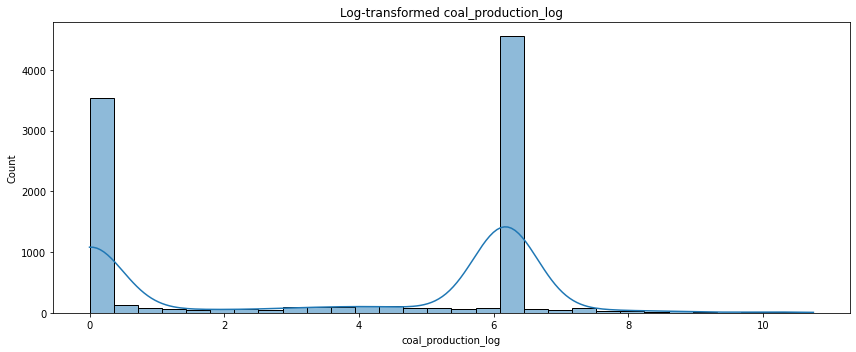

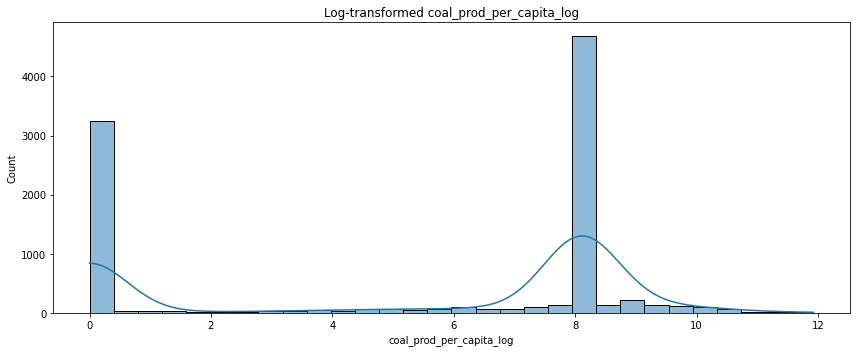

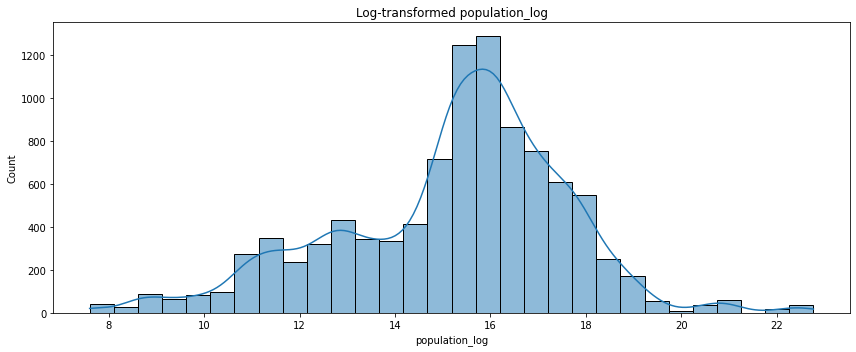

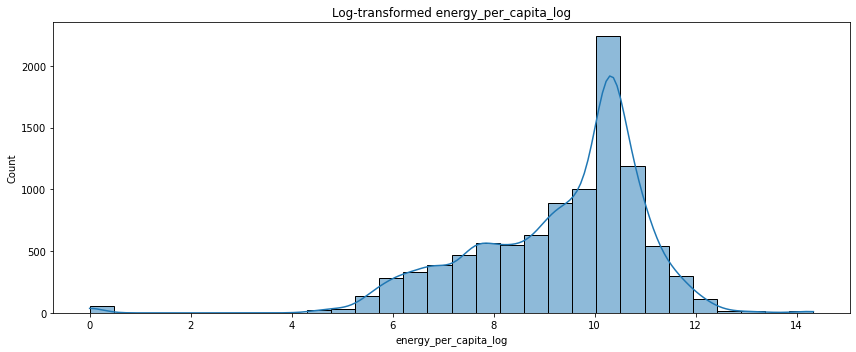

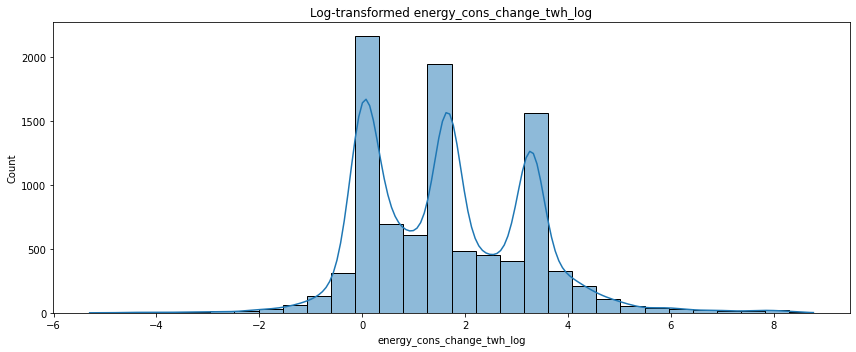

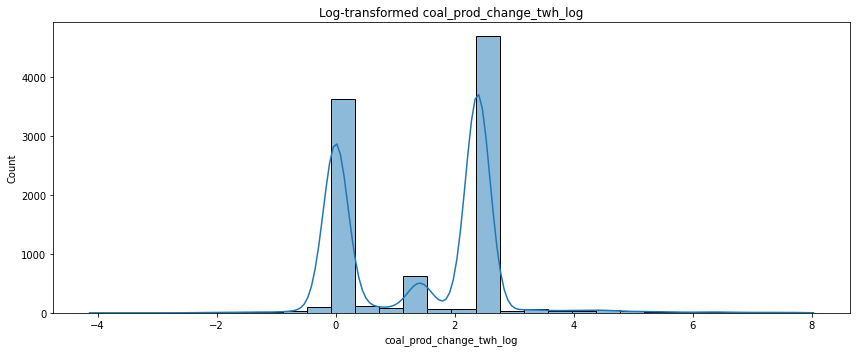

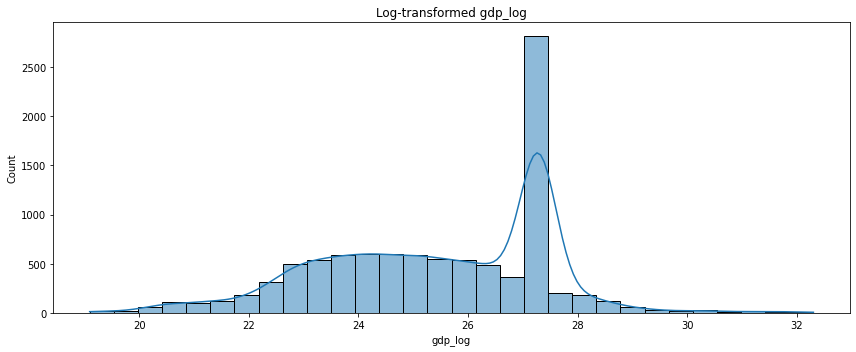

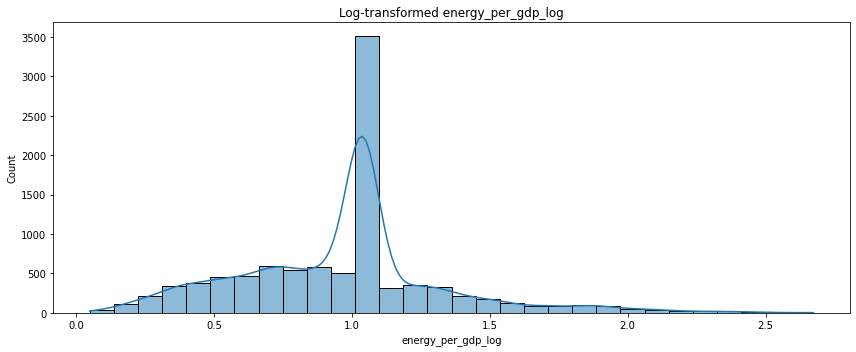

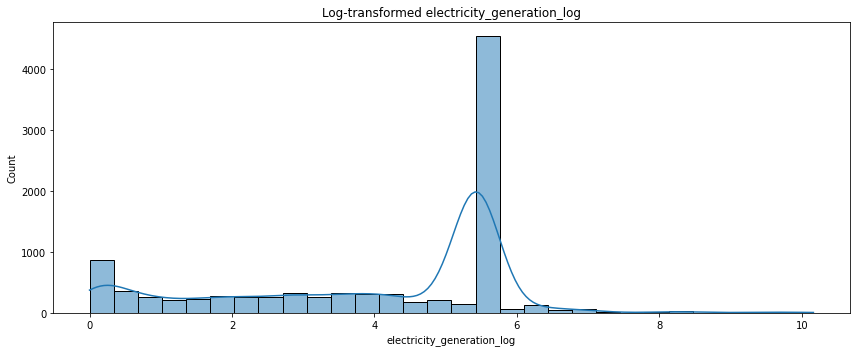

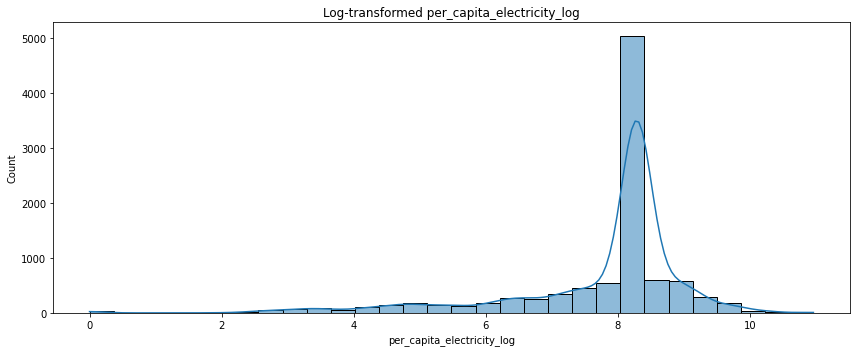

In [8]:
# Generate histograms for the transformed features
for feature in transformed_features:
    plt.figure(figsize=(12, 5))
    
    sns.histplot(transformed_data_pd[f"{feature}"], bins=30, kde=True)
    plt.title(f'Log-transformed {feature}')
    
    plt.tight_layout()
    plt.show()

In [9]:
# Convert Spark DataFrame to Pandas for Spearman correlation
merged_data_pd = merged_data.toPandas()

# Compute Spearman correlation in Pandas and find the top features
spearman_correlations = merged_data_pd.corr(method='spearman')['primary_energy_consumption'].sort_values(ascending=False)
high_corr_features_spearman = spearman_correlations.index[1:11].tolist()  # top 10 features

print(f"Top 10 features based on Spearman correlation: {high_corr_features_spearman}")

# Transform features
for feature in high_corr_features_spearman:
    merged_data = merged_data.withColumn(f"{feature}_log", log(F.col(feature) + 1))

Top 10 features based on Spearman correlation: ['energy_cons_change_twh_log', 'coal_production_log', 'coal_production', 'coal_prod_per_capita_log', 'coal_prod_per_capita', 'population', 'population_log', 'coal_prod_change_twh_log', 'energy_per_capita', 'energy_per_capita_log']


In [10]:
# Descriptive statistics
for feature in high_corr_features_spearman:
    merged_data.select(f"{feature}_log").describe().show()


+-------+------------------------------+
|summary|energy_cons_change_twh_log_log|
+-------+------------------------------+
|  count|                          9620|
|   mean|            0.8108628307662393|
| stddev|            0.6713639771522166|
|    min|            -8.023536554434806|
|    max|            2.2794695415601107|
+-------+------------------------------+

+-------+-----------------------+
|summary|coal_production_log_log|
+-------+-----------------------+
|  count|                   9773|
|   mean|     1.1885819214674433|
| stddev|     0.9290769448102926|
|    min|                    0.0|
|    max|     2.4637065218887737|
+-------+-----------------------+

+-------+-------------------+
|summary|coal_production_log|
+-------+-------------------+
|  count|               9773|
|   mean| 3.6344006107205225|
| stddev| 2.9903502802888444|
|    min|                0.0|
|    max|   10.7482761817199|
+-------+-------------------+

+-------+----------------------------+
|summary|coal

In [11]:
# Define the countries to analyze
countries_to_analyze = ['United States', 'Australia', 'Brazil', 'China', 'Japan', 'France', 'Europe', 'New Zealand']
country_models = {}

# Loop through each country to filter data and generate regression models
# Loop through each country to filter data and generate regression models
for country in countries_to_analyze:
    country_data = merged_data.filter(F.col("country") == country)
    
    if country_data.count() < 2:
        print(f"Skipping {country} due to insufficient data.")
        continue
    
    # Create a vector assembler that takes top 10 features and produces a new column called 'features'
    vec_assembler = VectorAssembler(inputCols=high_corr_features_spearman, outputCol="features")
    
    # Use the assembler to transform our DataFrame to the two-column format
    country_data = vec_assembler.transform(country_data)
    
    
    # Fit the linear regression model
    lr = LinearRegression(featuresCol='features', labelCol='primary_energy_consumption')
    lr_model = lr.fit(country_data)
    
    # Store the model in the dictionary
    country_models[country] = lr_model
    
    # Print coefficients for each country
    print(f"Coefficients for {country}: {lr_model.coefficients}")

# Filter out the data for the countries to analyze
filtered_data = merged_data.filter(F.col('country').isin(countries_to_analyze))

# Create a vector assembler that takes top 10 features and produces a new column called 'features'
vec_assembler = VectorAssembler(inputCols=high_corr_features_spearman, outputCol="features")

# Use the assembler to transform our DataFrame to the two-column format
filtered_data = vec_assembler.transform(filtered_data)

# Split the data into training and test sets (70% training, 30% testing)
train_data, test_data = filtered_data.randomSplit([0.7, 0.3], seed=42)

# Create and fit the regression model
lr = LinearRegression(featuresCol='features', labelCol='primary_energy_consumption')
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="primary_energy_consumption", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

print(f"Model R-squared: {r2}")


23/10/09 04:52:27 WARN Instrumentation: [d54a9f09] regParam is zero, which might cause numerical instability and overfitting.
23/10/09 04:52:27 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients for United States: [-3.3324464891232397,2359.65206629886,0.5640748048898305,-3699.0414288984744,-0.04098928748540604,5.6861692900770096e-05,2379.8245206815186,-7.746339498300129,0.4945862153486234,-21122.446167875485]


23/10/09 04:52:29 WARN Instrumentation: [021b78e6] regParam is zero, which might cause numerical instability and overfitting.


Coefficients for Australia: [-0.5225966266708777,31.884103332954,0.30961671130169727,95.66342686811358,-0.007540779527602471,-1.330136601564063e-05,857.6517572157483,0.18955072696599218,0.04213604450349116,-1413.618818375435]


23/10/09 04:52:30 WARN Instrumentation: [a5778964] regParam is zero, which might cause numerical instability and overfitting.


Coefficients for Brazil: [16.241215859530797,-4053.646312423879,17.791487020214205,3934.9528558591496,-2.2531916120218187,5.294168951475034e-05,-1643.8411668396516,-10.82422193591515,0.18094504701284478,-1416.4943392141583]


23/10/09 04:52:32 WARN Instrumentation: [4e19a630] regParam is zero, which might cause numerical instability and overfitting.


Coefficients for China: [-14.224706336388552,-2963.0726115410257,2.0299322525990733,6465.179065346212,-3.0758131245720515,-1.7129898478494422e-05,18897.764569279138,10.397101276300905,1.4914700170348294,-2174.4697716123073]


23/10/09 04:52:34 WARN Instrumentation: [aaaa914c] regParam is zero, which might cause numerical instability and overfitting.


Coefficients for Japan: [0.08444224985035474,67.67692334799064,1.5195058755365094,-68.93365259105829,-0.24691778517909138,1.0364041665807599e-05,2642.2988955029746,-1.5953630399597907,0.17986428170675361,-2278.6186232053205]


23/10/09 04:52:35 WARN Instrumentation: [86f5abd7] regParam is zero, which might cause numerical instability and overfitting.
23/10/09 04:52:35 WARN Instrumentation: [86f5abd7] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/10/09 04:52:35 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
23/10/09 04:52:35 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
23/10/09 04:52:35 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
23/10/09 04:52:35 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
23/10/09 04:52:35 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
23/10/09 04:52:35 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
23/10/09 04:52:35 ERROR L

Coefficients for France: [28.600669654768517,57290884396.9051,0.0,-18987780640.311104,0.0,0.0007572784420779586,-44268.723429340214,0.0,0.031636895225805976,1120.4542482434792]
Skipping Europe due to insufficient data.


23/10/09 04:52:37 WARN Instrumentation: [34b2c20c] regParam is zero, which might cause numerical instability and overfitting.


Coefficients for New Zealand: [0.3312517908259687,65.23676791448247,-0.5225145244728582,-74.75418436192957,0.0036613523774375436,1.380062527937388e-05,104.1442256219047,-0.048138410548808006,0.005981102744263663,-136.9818262955574]


23/10/09 04:52:39 WARN Instrumentation: [d0f5542e] regParam is zero, which might cause numerical instability and overfitting.


Model R-squared: 0.9672118273250234
